In [3]:
# !pip install torch
# !pip install scikit-learn
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install h5py

# Classifier with multi matrix

# Init

Using device: cuda
Creating data pointers by scanning NPZ files...
Scan complete. Found 18083 total segments.
Total number of segments in PIAST-AT dataset: 18083
Splitting dataset: Train=12658, Val=2712, Test=2713
Train loader: 12658 samples, Val loader: 2712 samples, Test loader: 2713 samples

--- Starting Training ---
Epoch 1/50 => Train Loss: 0.5337, Train Acc: 0.7413 | Val Loss: 0.5372, Val Acc: 0.7028
  Validation accuracy improved. Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier.pth
Epoch 2/50 => Train Loss: 0.4922, Train Acc: 0.7722 | Val Loss: 0.4513, Val Acc: 0.7850
  Validation accuracy improved. Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier.pth
Epoch 3/50 => Train Loss: 0.4743, Train Acc: 0.7828 | Val Loss: 0.8272, Val Acc: 0.5037
Epoch 4/50 => Train Loss: 0.4622, Train Acc: 0.7842 | Val Loss: 0.4344, Val Acc: 0.7987
  Validation accuracy improved. Model saved to C:\Users\User\Desktop\college

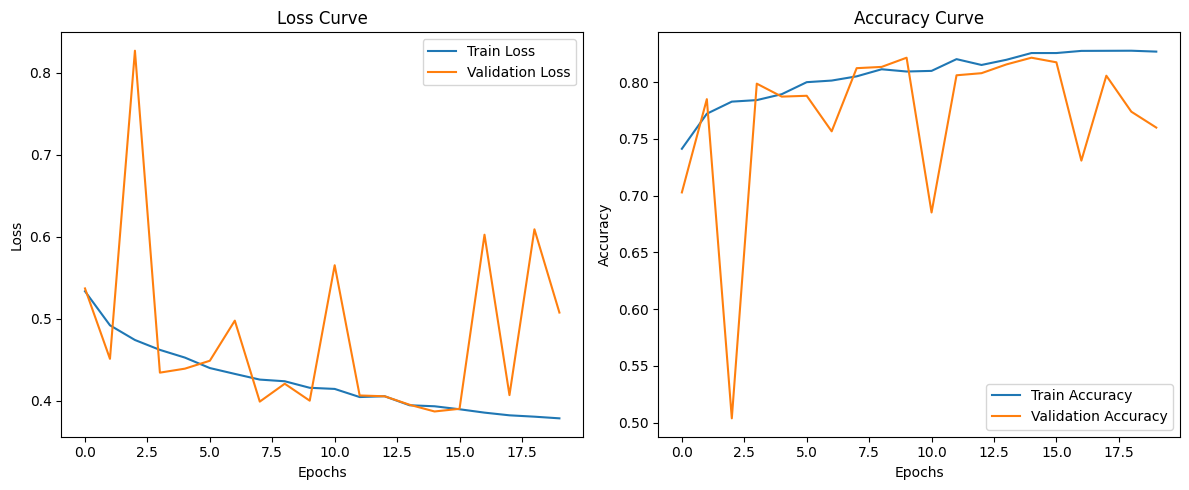


--- Evaluating on Test Set with Best Model ---
Test Loss: 0.4103, Test Accuracy: 0.8190

Classification Report (Test Set):
              precision    recall  f1-score   support

Non-Jazz (0)       0.82      0.91      0.86      1686
    Jazz (1)       0.82      0.67      0.74      1027

    accuracy                           0.82      2713
   macro avg       0.82      0.79      0.80      2713
weighted avg       0.82      0.82      0.81      2713

Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier.pth


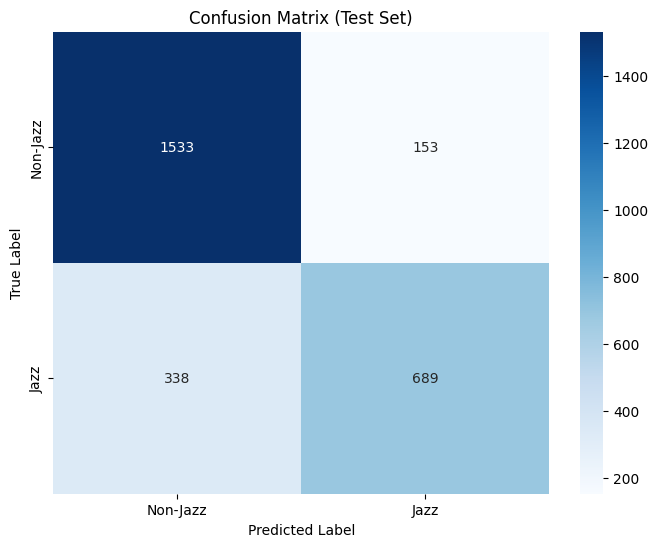

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
INPUT_HEIGHT = 88
INPUT_WIDTH = 128
NUM_CLASSES = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
# Increased patience is good for a model learning from more complex data
PATIENCE_EARLY_STOPPING = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- [UPDATED] Model Definition: JazzClassifierCNN ---
class JazzClassifierCNN(nn.Module):
    def __init__(self, input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, num_classes=NUM_CLASSES):
        super(JazzClassifierCNN, self).__init__()
        
        # --- THIS IS THE KEY CHANGE ---
        # The model now accepts 4 input channels instead of 1.
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 5), stride=1, padding=(1, 2))
        # --- END OF CHANGE ---
        
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x): # x should now be (batch_size, 4, height, width)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc_out(x)
    

class PianoRollSegmentDataset(Dataset):
    """
    A PyTorch Dataset to load the 4-channel pianoroll matrices
    (onset, sustain, velocity, offset) and segment them on-the-fly.
    """
    def __init__(self, matrix_filepaths, labels, segment_length=INPUT_WIDTH):
        self.matrix_filepaths = matrix_filepaths
        self.labels = labels
        self.segment_length = segment_length
        self.data_pointers = []

        print("Creating data pointers by scanning NPZ files...")
        for i, filepath in enumerate(self.matrix_filepaths):
            try:
                with np.load(filepath) as data:
                    # Use the 'onset' matrix to determine the length of the song
                    num_timesteps = data['onset'].shape[0]
                
                if num_timesteps < self.segment_length:
                    self.data_pointers.append((i, 0))
                    continue
                
                for start_step in range(0, num_timesteps - self.segment_length + 1, self.segment_length):
                    self.data_pointers.append((i, start_step))
            except Exception as e:
                print(f"Warning: Could not read or process {filepath}: {e}")

        if not self.data_pointers:
            raise ValueError("No valid data pointers could be created.")
        print(f"Scan complete. Found {len(self.data_pointers)} total segments.")

    def __len__(self):
        return len(self.data_pointers)

    def __getitem__(self, idx):
        file_idx, start_step = self.data_pointers[idx]
        filepath = self.matrix_filepaths[file_idx]
        label = self.labels[file_idx]

        with np.load(filepath) as data:
            # Load all four matrices
            onset = data['onset'].astype(np.float32)
            sustain = data['sustain'].astype(np.float32)
            velocity = data['velocity'].astype(np.float32)
            offset = data['offset'].astype(np.float32)

        # --- Slice, Pad, and Transpose all four matrices ---
        matrices = [onset, sustain, velocity, offset]
        processed_matrices = []
        
        for full_matrix in matrices:
            segment = full_matrix[start_step : start_step + self.segment_length, :]
            
            # Handle padding if the whole song was short
            current_timesteps = segment.shape[0]
            if current_timesteps < self.segment_length:
                padding_needed = self.segment_length - current_timesteps
                segment = np.pad(segment, ((0, padding_needed), (0, 0)), mode='constant')
            
            # Transpose from (Timesteps, Pitches) to (Pitches, Timesteps)
            processed_matrices.append(segment.T)

        # --- Stack the matrices to create the channel dimension ---
        # Shape becomes (4, 88, 128)
        multi_channel_matrix = np.stack(processed_matrices, axis=0)
        
        matrix_tensor = torch.from_numpy(multi_channel_matrix)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        
        return matrix_tensor, label_tensor


# --- Configuration and Helper Functions (No changes needed here) ---
BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices" # IMPORTANT: Use the new data folder
LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
MODEL_SAVE_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier.pth"
PLOT_SAVE_DIR = r"C:\Users\User\Desktop\college\fyp\models\plots"
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

def load_piast_at_data(base_matrix_dir, label_map_file):
    # This function is unchanged, it just works with file paths
    piast_at_matrix_filepaths, piast_at_labels = [], []
    with open(label_map_file, 'r') as f: full_label_map = json.load(f)
    for rel_path, label in full_label_map.items():
        if "piast/piast_at" in rel_path.lower():
            full_path = os.path.join(base_matrix_dir, rel_path)
            if os.path.exists(full_path):
                piast_at_matrix_filepaths.append(full_path)
                piast_at_labels.append(label)
    return piast_at_matrix_filepaths, piast_at_labels

def train_epoch(model, dataloader, criterion, optimizer, device):
    # This function is unchanged
    model.train()
    running_loss, correct_preds, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_preds += (preds == labels.bool()).sum().item()
        total += labels.size(0)
    return running_loss / total, correct_preds / total

def evaluate_model(model, dataloader, criterion, device):
    # This function is unchanged
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / len(dataloader.dataset), accuracy_score(all_labels, all_preds), np.array(all_labels), np.array(all_preds)


# --- Main Script ---
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    piast_at_files, piast_at_labels = load_piast_at_data(BASE_MATRIX_DIR, LABEL_MAP_FILE)
    if not piast_at_files:
        print("No PIAST-AT files found. Exiting.")
        exit()
    
    full_piast_at_dataset = PianoRollSegmentDataset(piast_at_files, piast_at_labels)

    print(f"Total number of segments in PIAST-AT dataset: {len(full_piast_at_dataset)}")

    dataset_size = len(full_piast_at_dataset)
    if dataset_size < 3: # Need at least 1 sample for train, val, test each for split
        print("Dataset too small to split into train, validation, and test. Exiting.")
        exit()
        
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    # Ensure test_size gets the remainder and is at least 1 if possible
    test_size = dataset_size - train_size - val_size 
    if test_size <= 0 and (train_size + val_size < dataset_size) : # if float math made it 0 but there are items left
        test_size = dataset_size - train_size - val_size
    elif test_size <=0 and val_size > 1: # borrow from val if test is 0 and val has enough
        val_size -=1
        test_size +=1
    elif test_size <=0 and train_size > 1: # borrow from train if test is 0 and train has enough
        train_size -=1
        test_size +=1


    print(f"Splitting dataset: Train={train_size}, Val={val_size}, Test={test_size}")
    
    if train_size == 0 or val_size == 0 or test_size == 0:
        print(f"Not enough data to create non-empty train/val/test splits. Resulting sizes: T={train_size},V={val_size},Te={test_size}. Adjust data or split ratios.")
        exit()
        
    train_dataset, val_dataset, test_dataset = random_split(full_piast_at_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Train loader: {len(train_loader.dataset)} samples, Val loader: {len(val_loader.dataset)} samples, Test loader: {len(test_loader.dataset)} samples")

    model = JazzClassifierCNN().to(DEVICE) # Removed redundant args, uses class defaults
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    patience = 10

    print("\n--- Starting Training ---")
    for epoch in range(NUM_EPOCHS): # Added epoch to global scope for debug print in train_epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} => "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"  Validation accuracy improved. Model saved to {MODEL_SAVE_PATH}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            # print(f"  Validation accuracy did not improve for {epochs_no_improve} epoch(s).") # Less verbose

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break
            
    print("\n--- Training Complete ---")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curve')
    plt.subplot(1, 2, 2); plt.plot(train_accs, label='Train Accuracy'); plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy Curve')
    plt.tight_layout(); plt.show()

    print("\n--- Evaluating on Test Set with Best Model ---")
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    test_loss, test_acc, test_all_labels, test_all_preds = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    print("\nClassification Report (Test Set):")
    test_all_labels_int = test_all_labels.astype(int)
    test_all_preds_int = test_all_preds.astype(int)
    print(classification_report(test_all_labels_int, test_all_preds_int, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

    cm = confusion_matrix(test_all_labels_int, test_all_preds_int)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Jazz', 'Jazz'], yticklabels=['Non-Jazz', 'Jazz'])
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix (Test Set)')

    print(f"Model saved to {MODEL_SAVE_PATH}")

## Model evaluation on other sets


  STARTING CAMPAIGN FOR MODEL: jazz_classifier.pth
Loading model: jazz_classifier.pth
--------------------------------------------------
Processing dataset: ADL (Multi-Channel Full)
Scanning files to create segment pointers for 'ADL (Multi-Channel Full)'...
Scan complete. Found 424903 total segments.


Evaluating Batches: 100%|██████████| 415/415 [09:29<00:00,  1.37s/it]



--- Evaluation Report for: ADL (Multi-Channel Full) ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.97      0.49      0.66    398784
    Jazz (1)       0.09      0.79      0.17     26119

    accuracy                           0.51    424903
   macro avg       0.53      0.64      0.41    424903
weighted avg       0.92      0.51      0.63    424903

--------------------------------------------------
Processing dataset: PIAST-YT (Multi-Channel Full)
Scanning files to create segment pointers for 'PIAST-YT (Multi-Channel Full)'...
Scan complete. Found 314088 total segments.


Evaluating Batches: 100%|██████████| 307/307 [13:18<00:00,  2.60s/it]  



--- Evaluation Report for: PIAST-YT (Multi-Channel Full) ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.84      0.86      0.85    230073
    Jazz (1)       0.59      0.56      0.57     84015

    accuracy                           0.78    314088
   macro avg       0.71      0.71      0.71    314088
weighted avg       0.77      0.78      0.77    314088

--------------------------------------------------
Processing dataset: PiJAMA (Multi-Channel Full)
Scanning files to create segment pointers for 'PiJAMA (Multi-Channel Full)'...
Scan complete. Found 156520 total segments.


Evaluating Batches: 100%|██████████| 153/153 [04:19<00:00,  1.70s/it]


--- Evaluation Report for: PiJAMA (Multi-Channel Full) ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.68      0.81    156520

    accuracy                           0.68    156520
   macro avg       0.50      0.34      0.41    156520
weighted avg       1.00      0.68      0.81    156520



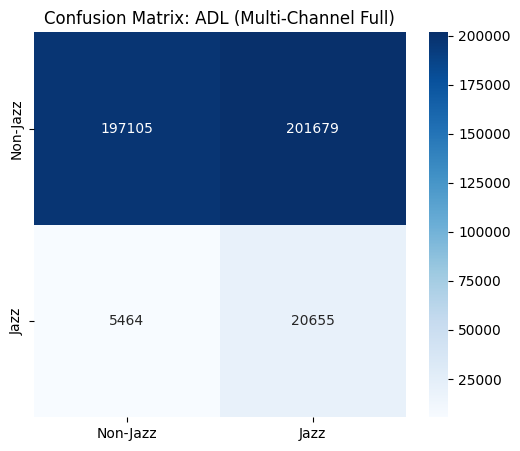

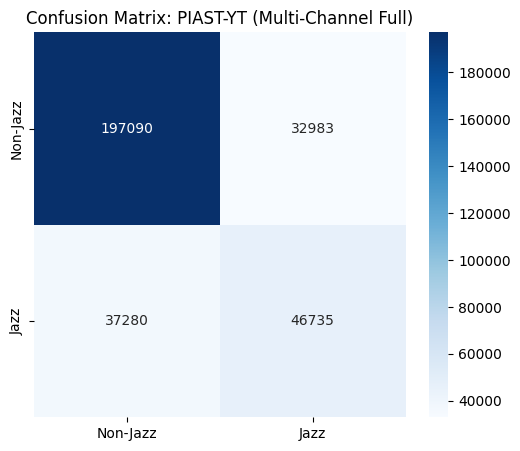

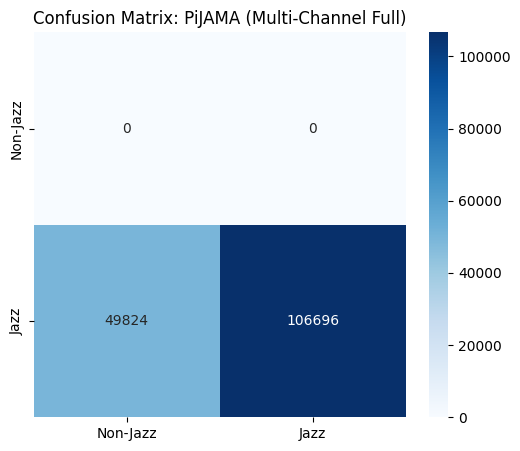

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from LazyLoading import MultiChannelLazyDataset

# ==============================================================================
# Cell 1: Required Class Definitions
# ==============================================================================

# --- Model Definition (Must be identical to the trained model) ---
# This version correctly expects 4 input channels.
class JazzClassifierCNN(nn.Module):
    def __init__(self, input_height=88, input_width=128, num_classes=1):
        super(JazzClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 5), stride=1, padding=(1, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = self.dropout1(x)
        x = F.relu(self.fc2(x)); x = self.dropout2(x)
        return self.fc_out(x)


# ==============================================================================
# Cell 2: The ModelEvaluator Class
# ==============================================================================
class ModelEvaluator:
    # This class remains largely the same, as its logic is sound.
    # It correctly uses the dataset abstraction.
    def __init__(self, base_matrix_dir, label_map_file, batch_size=64, num_workers=4, device=None):
        self.base_matrix_dir = base_matrix_dir
        self.label_map_file = label_map_file
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = nn.BCEWithLogitsLoss()

    def _load_model(self, model_path):
        try:
            print(f"Loading model: {os.path.basename(model_path)}")
            # The class now correctly expects 4 input channels
            model = JazzClassifierCNN().to(self.device)
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            model.eval()
            return model
        except Exception as e:
            print(f"ERROR: Could not load model at {model_path}: {e}")
            return None

    # _load_dataset_paths, _run_single_evaluation, _generate_report_and_plot are unchanged...
    def _load_dataset_paths(self, identifier_key):
        filepaths, labels = [], []
        with open(self.label_map_file, 'r') as f: full_label_map = json.load(f)
        for rel_path, label in full_label_map.items():
            if identifier_key in rel_path.lower().replace('\\', '/'):
                full_path = os.path.join(self.base_matrix_dir, rel_path)
                if os.path.exists(full_path):
                    filepaths.append(full_path)
                    labels.append(label)
        return filepaths, labels

    def _run_single_evaluation(self, model, dataloader):
        all_preds, all_labels = [], []
        # [NEW] Use tqdm for a progress bar, which is essential for long evaluations
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating Batches"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                all_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        return np.array(all_labels), np.array(all_preds)

    def _generate_report_and_plot(self, y_true, y_pred, dataset_name):
        print(f"\n--- Evaluation Report for: {dataset_name} ---")
        print(classification_report(y_true, y_pred, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Jazz', 'Jazz'], yticklabels=['Non-Jazz', 'Jazz'])
        plt.title(f'Confusion Matrix: {dataset_name}')
        
    def run_evaluation_campaign(self, model_path, datasets_to_evaluate):
        print("\n" + "="*60 + f"\n  STARTING CAMPAIGN FOR MODEL: {os.path.basename(model_path)}\n" + "="*60)
        model = self._load_model(model_path)
        if model is None: return

        for dataset_info in datasets_to_evaluate:
            print("-" * 50 + f"\nProcessing dataset: {dataset_info['name']}")
            filepaths, labels = self._load_dataset_paths(dataset_info['identifier_key'])
            if not filepaths: continue

            # --- Use the new multi-channel dataset ---
            eval_dataset = MultiChannelLazyDataset(filepaths, labels, dataset_name=dataset_info['name'])
            if len(eval_dataset) == 0: continue
            
            # Create the DataLoader with multiple workers to speed up lazy loading
            eval_loader = DataLoader(
                eval_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers, # Use background processes
                pin_memory=True if self.device.type == 'cuda' else False # Speeds up CPU to GPU transfer
            )
            # --- END OF CHANGE ---

            y_true, y_pred = self._run_single_evaluation(model, eval_loader)
            self._generate_report_and_plot(y_true, y_pred, dataset_info['name'])


# ==============================================================================
# Cell 3: Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    # --- IMPORTANT: Update path to the multi-channel data ---
    BASE_MATRIX_DIR_MC = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    LABEL_MAP_FILE_MC = os.path.join(BASE_MATRIX_DIR_MC, "master_label_map.json")
    
    # --- Create an instance of the evaluator ---
    # We can set the number of workers for the DataLoader here.
    # A good starting point is half the number of your CPU cores.
    evaluator = ModelEvaluator(
        base_matrix_dir=BASE_MATRIX_DIR_MC,
        label_map_file=LABEL_MAP_FILE_MC,
        batch_size=1024, # You can use a larger batch size now
        num_workers=15    # Adjust based on your CPU
    )

    # --- Define the model and datasets to test ---
    model_path = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier.pth"
    
    datasets_to_test = [
        {"identifier_key": "adl", "name": "ADL (Multi-Channel Full)"},
        {"identifier_key": "piast/piast_yt", "name": "PIAST-YT (Multi-Channel Full)"},
        {"identifier_key": "pijama", "name": "PiJAMA (Multi-Channel Full)"},
    ]
    
    evaluator.run_evaluation_campaign(model_path, datasets_to_test)

# Data allocation

In [2]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ==============================================================================
# Configuration
# ==============================================================================

# --- Inputs ---
BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")

# --- Outputs ---
ALLOCATION_METADATA_DIR = r"C:\Users\User\Desktop\college\fyp\models\classifier_model"
TRAIN_ALLOC_OUTPUT_FILE = os.path.join(ALLOCATION_METADATA_DIR, "balanced_split_train.json")
EVAL_ALLOC_OUTPUT_FILE = os.path.join(ALLOCATION_METADATA_DIR, "balanced_split_eval_test.json")

os.makedirs(ALLOCATION_METADATA_DIR, exist_ok=True)

# --- Define the splitting strategy for each dataset group ---
DATASET_SPLIT_CONFIG = {
    # Smaller, high-variance jazz sets get an 80/20 split
    "ADL_Jazz":         {"identifier_key": os.path.join("adl", "jazz"), "train_ratio": 0.8, "is_jazz": True},
    "PiAST_YT_Jazz":    {"identifier_key": os.path.join("piast", "piast_yt", "jazz"), "train_ratio": 0.8, "is_jazz": True},
    
    # Larger or higher-quality sets get a 50/50 split
    "PIAST_AT_Jazz":    {"identifier_key": os.path.join("piast", "piast_at", "jazz"), "train_ratio": 0.8, "is_jazz": True},
    "PiJAMA_Jazz":      {"identifier_key": "pijama", "train_ratio": 0.5, "is_jazz": True},
    
    # Non-jazz sets also get a default 50/50 split, but will be capped
    "ADL_NonJazz":      {"identifier_key": os.path.join("adl", "non_jazz"), "train_ratio": 0.5, "is_jazz": False},
    "PiAST_YT_NonJazz": {"identifier_key": os.path.join("piast", "piast_yt", "non_jazz"), "train_ratio": 0.5, "is_jazz": False},
    "PiAST_AT_NonJazz": {"identifier_key": os.path.join("piast", "piast_at", "non_jazz"), "train_ratio": 0.5, "is_jazz": False},
}

# --- Balancing Configuration ---
# The total number of non-jazz samples in the training set will be capped
# at this multiple of the total jazz samples.
NON_JAZZ_TO_JAZZ_RATIO_CAP = 1.5

# ==============================================================================
# Main Allocation Logic
# ==============================================================================

def create_balanced_allocation():
    if not os.path.exists(LABEL_MAP_FILE):
        raise FileNotFoundError(f"ERROR: Master label map file not found at {LABEL_MAP_FILE}")

    with open(LABEL_MAP_FILE, 'r') as f:
        full_label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}

    # --- Stage 1: Initial filtering and splitting for all groups ---
    print("--- Stage 1: Initial Splitting for All Dataset Groups ---")
    
    all_group_files = {}
    jazz_train_pool = []
    non_jazz_groups = {} # Store non-jazz splits temporarily

    for group_name, info in DATASET_SPLIT_CONFIG.items():
        key = info["identifier_key"].replace('\\', '/')
        train_ratio = info["train_ratio"]
        
        group_files = [path for path in full_label_map if path.lower().startswith(key.lower())]
        if not group_files:
            print(f"  - No files found for group '{group_name}'. Skipping.")
            continue
        
        # Perform the initial split for this group
        train_paths, eval_paths = train_test_split(group_files, train_size=train_ratio, random_state=42, shuffle=True)
        
        print(f"  - Group '{group_name}': Found {len(group_files)} files -> Split into {len(train_paths)} Train / {len(eval_paths)} Eval.")
        
        if info["is_jazz"]:
            jazz_train_pool.extend(train_paths)
        else:
            # Store non-jazz splits to be processed in the capping stage
            non_jazz_groups[group_name] = {'train': train_paths, 'eval': eval_paths}

    # --- Stage 2: Capping and Balancing the Non-Jazz Training Pool ---
    print("\n--- Stage 2: Balancing Non-Jazz Training Data ---")
    
    total_jazz_train_files = len(jazz_train_pool)
    global_non_jazz_cap = int(total_jazz_train_files * NON_JAZZ_TO_JAZZ_RATIO_CAP)
    num_non_jazz_sets = len(non_jazz_groups)
    per_dataset_non_jazz_cap = global_non_jazz_cap // num_non_jazz_sets if num_non_jazz_sets > 0 else 0

    print(f"Total Jazz training files: {total_jazz_train_files}")
    print(f"Global Non-Jazz training cap (at {NON_JAZZ_TO_JAZZ_RATIO_CAP}x): {global_non_jazz_cap}")
    print(f"Per-dataset Non-Jazz cap: {per_dataset_non_jazz_cap}")

    non_jazz_train_pool = []
    final_evaluation_pool = [] # This will hold all eval files, including capped-out ones

    for group_name, paths in non_jazz_groups.items():
        train_paths = paths['train']
        eval_paths = paths['eval']
        
        # Shuffle the train paths before capping to ensure randomness
        np.random.shuffle(train_paths)
        
        # Apply the per-dataset cap
        capped_train_paths = train_paths[:per_dataset_non_jazz_cap]
        # Any files that were "capped out" are moved to the evaluation pool
        capped_out_paths = train_paths[per_dataset_non_jazz_cap:]
        
        non_jazz_train_pool.extend(capped_train_paths)
        final_evaluation_pool.extend(eval_paths)
        final_evaluation_pool.extend(capped_out_paths) # Add capped files to eval
        
        print(f"  - Group '{group_name}': Capped training set from {len(train_paths)} to {len(capped_train_paths)}. "
              f"({len(capped_out_paths)} files moved to eval pool)")

    # Final training pool is the combination of all jazz and capped non-jazz
    final_training_pool = jazz_train_pool + non_jazz_train_pool
    np.random.shuffle(final_training_pool)

    # --- Stage 3: Splitting the Evaluation Pool into Validation and Test Sets ---
    print("\n--- Stage 3: Splitting Final Evaluation Pool into Validation/Test ---")
    
    # Add the evaluation files from the jazz splits to the final pool
    for group_name, info in DATASET_SPLIT_CONFIG.items():
        if info["is_jazz"]:
            key = info["identifier_key"].replace('\\', '/')
            group_files = [path for path in full_label_map if path.lower().startswith(key.lower())]
            if group_files:
                _, eval_paths = train_test_split(group_files, train_size=info["train_ratio"], random_state=42, shuffle=True)
                final_evaluation_pool.extend(eval_paths)
    
    np.random.shuffle(final_evaluation_pool)
    
    # Split the combined evaluation pool 50/50 into validation and test
    validation_paths, test_paths = train_test_split(final_evaluation_pool, test_size=0.7, random_state=42, shuffle=True)
    
    print(f"Total files for evaluation: {len(final_evaluation_pool)}")
    print(f"  - Validation set size: {len(validation_paths)}")
    print(f"  - Test set size: {len(test_paths)}")

    # --- Stage 4: Saving Final Allocation Files ---
    print("\n" + "="*50)
    print("--- Saving Final Allocation Files ---")

    with open(TRAIN_ALLOC_OUTPUT_FILE, 'w') as f:
        json.dump(final_training_pool, f, indent=4)
    print(f"Training pool saved to: {TRAIN_ALLOC_OUTPUT_FILE}")
    print(f"  - Total files: {len(final_training_pool)}")

    eval_data_to_save = {
        "validation": validation_paths,
        "test": test_paths
    }
    with open(EVAL_ALLOC_OUTPUT_FILE, 'w') as f:
        json.dump(eval_data_to_save, f, indent=4)
    print(f"Evaluation & Test pools saved to: {EVAL_ALLOC_OUTPUT_FILE}")
    
    print("\n--- Data Allocation Complete ---")

# ==============================================================================
# Run the Script
# ==============================================================================

if __name__ == "__main__":
    create_balanced_allocation()

--- Stage 1: Initial Splitting for All Dataset Groups ---
  - Group 'ADL_Jazz': Found 331 files -> Split into 264 Train / 67 Eval.
  - Group 'PiAST_YT_Jazz': Found 1312 files -> Split into 1049 Train / 263 Eval.
  - Group 'PIAST_AT_Jazz': Found 589 files -> Split into 471 Train / 118 Eval.
  - Group 'PiJAMA_Jazz': Found 1636 files -> Split into 818 Train / 818 Eval.
  - Group 'ADL_NonJazz': Found 6442 files -> Split into 3221 Train / 3221 Eval.
  - Group 'PiAST_YT_NonJazz': Found 3314 files -> Split into 1657 Train / 1657 Eval.
  - Group 'PiAST_AT_NonJazz': Found 810 files -> Split into 405 Train / 405 Eval.

--- Stage 2: Balancing Non-Jazz Training Data ---
Total Jazz training files: 2602
Global Non-Jazz training cap (at 1.5x): 3903
Per-dataset Non-Jazz cap: 1301
  - Group 'ADL_NonJazz': Capped training set from 3221 to 1301. (1920 files moved to eval pool)
  - Group 'PiAST_YT_NonJazz': Capped training set from 1657 to 1301. (356 files moved to eval pool)
  - Group 'PiAST_AT_NonJazz':

# Retrain on imbalance handled splits

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from DataLoading import MultiChannelLazyDataset, MultiChannelChunkedDataset

# ==============================================================================
# Cell 1: Configuration
# ==============================================================================
class TrainingConfig:
    # --- Paths ---
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    ALLOCATION_DIR = r"C:\Users\User\Desktop\college\fyp\models\classifier_model"
    TRAIN_FILE = os.path.join(ALLOCATION_DIR, "balanced_split_train.json")
    EVAL_TEST_FILE = os.path.join(ALLOCATION_DIR, "balanced_split_eval_test.json")
    MODEL_SAVE_PATH = os.path.join(ALLOCATION_DIR, "jazz_classifier_balanced.pth")
    PLOT_SAVE_DIR = r"C:\Users\User\Desktop\college\fyp\models\plots\balanced_classifier"

    # --- Training Hyperparameters ---
    BATCH_SIZE = 1024
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    PATIENCE_EARLY_STOPPING = 15
    NUM_WORKERS = 15
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Oversampling Configuration ---
    OVERSAMPLE_KEY = "adl/jazz"
    OVERSAMPLE_FACTOR = 3

    CACHE_SIZE = 1000

    # --- Evaluation Configuration ---
    # This mirrors the keys used in your allocation script for per-group evaluation
    DATASET_GROUPS_FOR_EVAL = {
        "ADL_Jazz":         {"identifier_key": "adl/jazz"},
        "PiAST_YT_Jazz":    {"identifier_key": "piast/piast_yt/jazz"},
        "PIAST_AT_Jazz":    {"identifier_key": "piast/piast_at/jazz"},
        "PiJAMA_Jazz":      {"identifier_key": "pijama"},
        "ADL_NonJazz":      {"identifier_key": "adl/non_jazz"},
        "PiAST_YT_NonJazz": {"identifier_key": "piast/piast_yt/non_jazz"},
        "PiAST_AT_NonJazz": {"identifier_key": "piast/piast_at/non_jazz"},
    }

# ==============================================================================
# Cell 2: Model Definition
# ==============================================================================
class JazzClassifierCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(JazzClassifierCNN, self).__init__()
        
        # --- THIS IS THE KEY CHANGE ---
        # The model now accepts 4 input channels instead of 1.
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 5), stride=1, padding=(1, 2))
        # --- END OF CHANGE ---
        
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x): # x should now be (batch_size, 4, height, width)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc_out(x)



# ==============================================================================
# Cell 3: The ClassifierTrainer Class
# ==============================================================================
class ClassifierTrainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = JazzClassifierCNN().to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.LEARNING_RATE)
        os.makedirs(config.PLOT_SAVE_DIR, exist_ok=True)

    def _load_data(self):
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            master_label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        with open(self.config.TRAIN_FILE, 'r') as f:
            train_paths = json.load(f)
        with open(self.config.EVAL_TEST_FILE, 'r') as f:
            eval_test_data = json.load(f)
            val_paths = eval_test_data['validation']
            self.test_paths = eval_test_data['test'] # Store for later evaluation

        # --- Perform Oversampling ---
        oversampled_train_paths = []
        for path in train_paths:
            oversampled_train_paths.append(path)
            if self.config.OVERSAMPLE_KEY in path.lower().replace('\\', '/'):
                for _ in range(self.config.OVERSAMPLE_FACTOR - 1):
                    oversampled_train_paths.append(path)
        np.random.shuffle(oversampled_train_paths)
        
        # --- Create File and Label Lists ---
        get_lists = lambda paths: ([os.path.join(self.config.BASE_MATRIX_DIR, p) for p in paths], [master_label_map[p] for p in paths])
        self.train_files, self.train_labels = get_lists(oversampled_train_paths)
        self.val_files, self.val_labels = get_lists(val_paths)
        self.test_labels = [master_label_map[p] for p in self.test_paths] # Get labels for test paths
        
    def _train_epoch(self, dataloader):
        self.model.train(); running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(dataloader, desc="Training"):
            inputs, labels = inputs.to(self.device), labels.to(self.device); self.optimizer.zero_grad()
            outputs = self.model(inputs); loss = self.criterion(outputs, labels); loss.backward(); self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5; correct += (preds == labels.bool()).sum().item(); total += labels.size(0)
        return running_loss / total, correct / total

    def _evaluate(self, dataloader):
        self.model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device); outputs = self.model(inputs)
                all_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        return np.array(all_labels), np.array(all_preds)

    def train(self):
        self._load_data()
        print("\n--- Creating Eager-Loading Training Dataset ---")
        train_dataset = MultiChannelChunkedDataset(
            self.train_files, self.train_labels, 
            cache_size=self.config.CACHE_SIZE, dataset_name="Train"
        )
        val_dataset = MultiChannelChunkedDataset(
            self.val_files, self.val_labels, 
            cache_size=self.config.CACHE_SIZE // 2, dataset_name="Validation" # Use a smaller cache for validation
        )
        # For an eager dataset, num_workers=0 is often fine and avoids overhead
        train_loader = DataLoader(train_dataset, batch_size=self.config.BATCH_SIZE, shuffle=True, num_workers=self.config.NUM_WORKERS)
        val_loader = DataLoader(val_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)

        best_val_acc = 0.0; epochs_no_improve = 0
        print("\n" + "="*50 + "\n--- Starting Model Training ---")
        for epoch in range(self.config.NUM_EPOCHS):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_labels_np, val_preds_np = self._evaluate(val_loader)
            val_acc = accuracy_score(val_labels_np, val_preds_np)
            print(f"Epoch {epoch+1}/{self.config.NUM_EPOCHS} => Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc; torch.save(self.model.state_dict(), self.config.MODEL_SAVE_PATH)
                print(f"  Validation accuracy improved! Model saved to {self.config.MODEL_SAVE_PATH}"); epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= self.config.PATIENCE_EARLY_STOPPING:
                print(f"Early stopping at epoch {epoch+1}."); break
        
        print("\n--- Training Complete ---")
        self.run_evaluation_campaign()

    def run_evaluation_campaign(self):
        print("\n" + "="*50 + "\n--- Final Evaluation on Test Subsets ---")
        best_model = JazzClassifierCNN().to(self.device)
        best_model.load_state_dict(torch.load(self.config.MODEL_SAVE_PATH))

        test_files_full_path = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in self.test_paths]

        print("\n--- Overall Test Set Performance ---")
        overall_dataset = MultiChannelLazyDataset(test_files_full_path, self.test_labels, dataset_name="Overall Test")
        overall_loader = DataLoader(overall_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
        y_true, y_pred = self._evaluate(overall_loader)
        print(classification_report(y_true, y_pred, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

        print("\n--- Per-Group Test Set Performance Breakdown ---")
        for group_name, info in self.config.DATASET_GROUPS_FOR_EVAL.items():
            key = info["identifier_key"].replace('\\', '/')
            group_files = [f for f, p in zip(test_files_full_path, self.test_paths) if key in p.lower()]
            if not group_files: continue
            group_labels = [l for f, l in zip(self.test_paths, self.test_labels) if key in f.lower()]
            
            group_dataset = MultiChannelLazyDataset(group_files, group_labels, dataset_name=group_name)
            if len(group_dataset) == 0: continue
            
            group_loader = DataLoader(group_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
            y_true_g, y_pred_g = self._evaluate(group_loader)
            print(f"\n--- Report for Group: {group_name} ---")
            print(classification_report(y_true_g, y_pred_g, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

# ==============================================================================
# Cell 5: Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    config = TrainingConfig()
    trainer = ClassifierTrainer(config)
    trainer.train()

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from DataLoading import MultiChannelLazyDataset
import torch.multiprocessing as mp

# ==============================================================================
# 1. Configuration
# ==============================================================================
class EvalConfig:
    # --- PATHS ---
    # The base directory where the multi-channel NPZ files are stored.
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    
    # The master label map for all NPZ files.
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    
    # The allocation file containing the 'test' set list.
    EVAL_TEST_FILE = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\balanced_split_eval_test.json"
    
    # --- [IMPORTANT] Path to the trained model you want to evaluate ---
    MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth"

    # --- Evaluation Hyperparameters ---
    BATCH_SIZE = 512  # Use a large batch size for fast inference
    NUM_WORKERS = 4   # Adjust based on your CPU cores
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Define the groups within the test set for detailed breakdown ---
    DATASET_GROUPS_FOR_EVAL = {
        "ADL_Jazz":         {"identifier_key": "adl/jazz"},
        "PiAST_YT_Jazz":    {"identifier_key": "piast/piast_yt/jazz"},
        "PIAST_AT_Jazz":    {"identifier_key": "piast/piast_at/jazz"},
        "PiJAMA_Jazz":      {"identifier_key": "pijama"},
        "ADL_NonJazz":      {"identifier_key": "adl/non_jazz"},
        "PiAST_YT_NonJazz": {"identifier_key": "piast/piast_yt/non_jazz"},
        "PiAST_AT_NonJazz": {"identifier_key": "piast/piast_at/non_jazz"},
    }

# ==============================================================================
# 2. Model Definition
# ==============================================================================
# This class must be identical to the one used for training.
class JazzClassifierCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(JazzClassifierCNN, self).__init__()
        self.conv1=nn.Conv2d(4,32,kernel_size=(3,5),padding=(1,2))
        self.bn1=nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=2,dilation=2)
        self.bn3=nn.BatchNorm2d(128)
        self.global_avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc1=nn.Linear(128,256)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(256,128)
        self.dropout2=nn.Dropout(0.5)
        self.fc_out=nn.Linear(128,num_classes)
    def forward(self, x):
        x=self.pool1(F.relu(self.bn1(self.conv1(x))))
        x=self.pool2(F.relu(self.bn2(self.conv2(x))))
        x=F.relu(self.bn3(self.conv3(x)))
        x=self.global_avg_pool(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=F.relu(self.fc2(x))
        x=self.dropout2(x)
        return self.fc_out(x)

# ==============================================================================
# 3. The ModelEvaluator Class
# ==============================================================================
class ModelEvaluator:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = self._load_model()
        self.test_files, self.test_labels = self._load_test_data()

    def _load_model(self):
        print(f"--- Loading model from: {self.config.MODEL_PATH} ---")
        if not os.path.exists(self.config.MODEL_PATH):
            raise FileNotFoundError(f"Model not found at '{self.config.MODEL_PATH}'")
        model = JazzClassifierCNN().to(self.device)
        model.load_state_dict(torch.load(self.config.MODEL_PATH, map_location=self.device))
        model.eval()
        print("Model loaded successfully.")
        return model

    def _load_test_data(self):
        print("--- Loading test data file paths ---")
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            master_label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        with open(self.config.EVAL_TEST_FILE, 'r') as f:
            test_relative_paths = json.load(f)['test']
        
        test_files = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in test_relative_paths]
        test_labels = [master_label_map[p] for p in test_relative_paths]
        print(f"Found {len(test_files)} files in the test set.")
        return test_files, test_labels

    def _evaluate_on_loader(self, dataloader):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating Batches"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                all_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        return np.array(all_labels), np.array(all_preds)

    def run_full_evaluation(self):
        if self.model is None or not self.test_files:
            print("Model or test files not loaded. Cannot run evaluation.")
            return

        # --- 1. Overall Test Set Evaluation ---
        print("\n" + "="*60 + "\n--- Overall Test Set Performance ---\n" + "="*60)
        overall_dataset = MultiChannelLazyDataset(self.test_files, self.test_labels, dataset_name="Overall Test")
        overall_loader = DataLoader(overall_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
        y_true, y_pred = self._evaluate_on_loader(overall_loader)
        
        print("\nClassification Report (Overall Test Set):")
        print(classification_report(y_true, y_pred, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))
        
        # --- 2. Per-Group Test Set Evaluation ---
        print("\n" + "="*60 + "\n--- Per-Group Test Set Performance Breakdown ---\n" + "="*60)
        for group_name, info in self.config.DATASET_GROUPS_FOR_EVAL.items():
            key = info["identifier_key"].replace('\\', '/')
            
            # Filter the file paths and labels for the current group
            group_files = [f for f in self.test_files if key in f.replace('\\', '/').lower()]
            group_labels = [l for f, l in zip(self.test_files, self.test_labels) if key in f.replace('\\', '/').lower()]

            if not group_files:
                print(f"\n--- No test files found for group: {group_name} ---")
                continue
            
            group_dataset = MultiChannelLazyDataset(group_files, group_labels, dataset_name=group_name)
            if len(group_dataset) == 0: continue
            
            group_loader = DataLoader(group_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
            y_true_g, y_pred_g = self._evaluate_on_loader(group_loader)
            
            print(f"\n--- Report for Group: {group_name} ---")
            print(classification_report(y_true_g, y_pred_g, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

# ==============================================================================
# 4. Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    config = EvalConfig()
    evaluator = ModelEvaluator(config)
    evaluator.run_full_evaluation()

--- Loading model from: C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth ---
Model loaded successfully.
--- Loading test data file paths ---
Found 6178 files in the test set.

--- Overall Test Set Performance ---
Scanning files to create segment pointers for 'Overall Test'...
Scan complete. Found 396379 total segments.


Evaluating Batches: 100%|██████████| 775/775 [15:09<00:00,  1.17s/it]  



Classification Report (Overall Test Set):
              precision    recall  f1-score   support

Non-Jazz (0)       0.98      0.82      0.89    327197
    Jazz (1)       0.52      0.93      0.67     69182

    accuracy                           0.84    396379
   macro avg       0.75      0.87      0.78    396379
weighted avg       0.90      0.84      0.85    396379


--- Per-Group Test Set Performance Breakdown ---
Scanning files to create segment pointers for 'ADL_Jazz'...
Scan complete. Found 3344 total segments.


Evaluating Batches: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]



--- Report for Group: ADL_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.77      0.87      3344

    accuracy                           0.77      3344
   macro avg       0.50      0.39      0.44      3344
weighted avg       1.00      0.77      0.87      3344

Scanning files to create segment pointers for 'PiAST_YT_Jazz'...
Scan complete. Found 11467 total segments.


Evaluating Batches: 100%|██████████| 23/23 [00:30<00:00,  1.33s/it]



--- Report for Group: PiAST_YT_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.77      0.87     11467

    accuracy                           0.77     11467
   macro avg       0.50      0.39      0.44     11467
weighted avg       1.00      0.77      0.87     11467

Scanning files to create segment pointers for 'PIAST_AT_Jazz'...
Scan complete. Found 835 total segments.


Evaluating Batches: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]



--- Report for Group: PIAST_AT_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.86      0.92       835

    accuracy                           0.86       835
   macro avg       0.50      0.43      0.46       835
weighted avg       1.00      0.86      0.92       835

Scanning files to create segment pointers for 'PiJAMA_Jazz'...
Scan complete. Found 53536 total segments.


Evaluating Batches: 100%|██████████| 105/105 [02:30<00:00,  1.43s/it]



--- Report for Group: PiJAMA_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.97      0.99     53536

    accuracy                           0.97     53536
   macro avg       0.50      0.49      0.49     53536
weighted avg       1.00      0.97      0.99     53536

Scanning files to create segment pointers for 'ADL_NonJazz'...
Scan complete. Found 225861 total segments.


Evaluating Batches: 100%|██████████| 442/442 [07:25<00:00,  1.01s/it]



--- Report for Group: ADL_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.85      0.92    225861
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.85    225861
   macro avg       0.50      0.43      0.46    225861
weighted avg       1.00      0.85      0.92    225861

Scanning files to create segment pointers for 'PiAST_YT_NonJazz'...
Scan complete. Found 96863 total segments.


Evaluating Batches: 100%|██████████| 190/190 [04:36<00:00,  1.45s/it]



--- Report for Group: PiAST_YT_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.75      0.86     96863
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.75     96863
   macro avg       0.50      0.37      0.43     96863
weighted avg       1.00      0.75      0.86     96863

Scanning files to create segment pointers for 'PiAST_AT_NonJazz'...
Scan complete. Found 4473 total segments.


Evaluating Batches: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


--- Report for Group: PiAST_AT_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.73      0.84      4473
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.73      4473
   macro avg       0.50      0.36      0.42      4473
weighted avg       1.00      0.73      0.84      4473



# 3 Matrix Classifier

In [1]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from DataLoading import MultiChannelEagerDataset, MultiChannelLazyDataset
import random

# ==============================================================================
# Cell 1: Configuration
# ==============================================================================
class TrainingConfig:
    # --- Paths ---
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    ALLOCATION_DIR = r"C:\Users\User\Desktop\college\fyp\models\classifier_model"
    TRAIN_FILE = os.path.join(ALLOCATION_DIR, "balanced_split_train.json")
    EVAL_TEST_FILE = os.path.join(ALLOCATION_DIR, "balanced_split_eval_test.json")
    MODEL_SAVE_PATH = os.path.join(ALLOCATION_DIR, "jazz_classifier_balanced_3channel.pth")
    PLOT_SAVE_DIR = r"C:\Users\User\Desktop\college\fyp\models\plots\balanced_classifier"

    # --- Training Hyperparameters ---
    BATCH_SIZE = 256
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    PATIENCE_EARLY_STOPPING = 15
    NUM_WORKERS = 15
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Oversampling Configuration ---
    OVERSAMPLE_KEY = "adl/jazz"
    OVERSAMPLE_FACTOR = 3

    # ***** MODIFICATION: Add a limit for files per group *****
    MAX_FILES_PER_GROUP = 300

    # --- Evaluation Configuration ---
    DATASET_GROUPS_FOR_EVAL = {
        "ADL_Jazz":         {"identifier_key": "adl/jazz"},
        "PiAST_YT_Jazz":    {"identifier_key": "piast/piast_yt/jazz"},
        "PIAST_AT_Jazz":    {"identifier_key": "piast/piast_at/jazz"},
        "PiJAMA_Jazz":      {"identifier_key": "pijama"},
        "ADL_NonJazz":      {"identifier_key": "adl/non_jazz"},
        "PiAST_YT_NonJazz": {"identifier_key": "piast/piast_yt/non_jazz"},
        "PiAST_AT_NonJazz": {"identifier_key": "piast/piast_at/non_jazz"},
    }

# ==============================================================================
# Cell 2: Model Definition (Unchanged)
# ==============================================================================
class JazzClassifierCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(JazzClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 5), stride=1, padding=(1, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = self.dropout1(x)
        x = F.relu(self.fc2(x)); x = self.dropout2(x)
        return self.fc_out(x)

# ==============================================================================
# Cell 3: The ClassifierTrainer Class
# ==============================================================================
class ClassifierTrainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = JazzClassifierCNN().to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.LEARNING_RATE)
        os.makedirs(config.PLOT_SAVE_DIR, exist_ok=True)

    def _load_data(self):
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            master_label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        with open(self.config.TRAIN_FILE, 'r') as f:
            train_paths_all = json.load(f)
        with open(self.config.EVAL_TEST_FILE, 'r') as f:
            eval_test_data = json.load(f)
            val_paths_all = eval_test_data['validation']
            self.test_paths_all = eval_test_data['test']

        # ***** MODIFICATION START: Helper function to limit files *****
        def limit_files(path_list, limit):
            """Randomly samples a subset of files from a list."""
            if len(path_list) > limit:
                return random.sample(path_list, limit)
            return path_list

        # Limit the number of files for training and validation before oversampling
        train_paths = limit_files(train_paths_all, self.config.MAX_FILES_PER_GROUP * len(self.config.DATASET_GROUPS_FOR_EVAL))
        val_paths = limit_files(val_paths_all, self.config.MAX_FILES_PER_GROUP * len(self.config.DATASET_GROUPS_FOR_EVAL))
        self.test_paths = limit_files(self.test_paths_all, self.config.MAX_FILES_PER_GROUP * len(self.config.DATASET_GROUPS_FOR_EVAL))
        
        print(f"--- Limiting data: Using at most {self.config.MAX_FILES_PER_GROUP} files per group ---")
        print(f"Original train size: {len(train_paths_all)}, Limited train size: {len(train_paths)}")
        print(f"Original val size: {len(val_paths_all)}, Limited val size: {len(val_paths)}")
        # ***** MODIFICATION END *****

        # --- Perform Oversampling on the LIMITED training set ---
        oversampled_train_paths = []
        for path in train_paths:
            oversampled_train_paths.append(path)
            if self.config.OVERSAMPLE_KEY in path.lower().replace('\\', '/'):
                for _ in range(self.config.OVERSAMPLE_FACTOR - 1):
                    oversampled_train_paths.append(path)
        np.random.shuffle(oversampled_train_paths)
        
        # --- Create File and Label Lists ---
        get_lists = lambda paths: ([os.path.join(self.config.BASE_MATRIX_DIR, p) for p in paths], [master_label_map[p] for p in paths])
        self.train_files, self.train_labels = get_lists(oversampled_train_paths)
        self.val_files, self.val_labels = get_lists(val_paths)
        self.test_labels = [master_label_map[p] for p in self.test_paths]
        
    def _train_epoch(self, dataloader):
        self.model.train(); running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(dataloader, desc="Training"):
            inputs = inputs[:, :3, :, :].to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)
        return running_loss / total, correct / total

    def _evaluate(self, dataloader):
        self.model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs = inputs[:, :3, :, :].to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                all_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        return np.array(all_labels), np.array(all_preds)

    def train(self):
        self._load_data()
        print("\n--- Creating Eager-Loading Training Dataset ---")
        # Using EagerDataset for potentially faster training with smaller, repeated data
        train_dataset = MultiChannelEagerDataset(self.train_files, self.train_labels, dataset_name="Train")
        val_dataset = MultiChannelEagerDataset(self.val_files, self.val_labels, dataset_name="Validation")
        
        train_loader = DataLoader(train_dataset, batch_size=self.config.BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=self.config.BATCH_SIZE, num_workers=0)

        best_val_acc = 0.0; epochs_no_improve = 0
        print("\n" + "="*50 + "\n--- Starting Model Training (3-Channel, Limited Data) ---")
        for epoch in range(self.config.NUM_EPOCHS):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_labels_np, val_preds_np = self._evaluate(val_loader)
            val_acc = accuracy_score(val_labels_np, val_preds_np)
            print(f"Epoch {epoch+1}/{self.config.NUM_EPOCHS} => Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), self.config.MODEL_SAVE_PATH)
                print(f"  Validation accuracy improved! Model saved to {self.config.MODEL_SAVE_PATH}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= self.config.PATIENCE_EARLY_STOPPING:
                print(f"Early stopping at epoch {epoch+1}.")
                break
        
        print("\n--- Training Complete ---")
        self.run_evaluation_campaign()

    def run_evaluation_campaign(self):
        print("\n" + "="*50 + "\n--- Final Evaluation on Test Subsets (3-Channel Model) ---")
        best_model = JazzClassifierCNN().to(self.device)
        best_model.load_state_dict(torch.load(self.config.MODEL_SAVE_PATH))

        test_files_full_path = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in self.test_paths]

        print("\n--- Overall Test Set Performance ---")
        overall_dataset = MultiChannelLazyDataset(test_files_full_path, self.test_labels, dataset_name="Overall Test")
        overall_loader = DataLoader(overall_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
        y_true, y_pred = self._evaluate(overall_loader)
        print(classification_report(y_true, y_pred, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

        print("\n--- Per-Group Test Set Performance Breakdown ---")
        for group_name, info in self.config.DATASET_GROUPS_FOR_EVAL.items():
            key = info["identifier_key"].replace('\\', '/')
            group_files = [f for f, p in zip(test_files_full_path, self.test_paths) if key in p.lower()]
            if not group_files: continue
            group_labels = [l for f, l in zip(self.test_paths, self.test_labels) if key in f.lower()]
            
            group_dataset = MultiChannelLazyDataset(group_files, group_labels, dataset_name=group_name)
            if len(group_dataset) == 0: continue
            
            group_loader = DataLoader(group_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
            y_true_g, y_pred_g = self._evaluate(group_loader)
            print(f"\n--- Report for Group: {group_name} ---")
            print(classification_report(y_true_g, y_pred_g, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

# ==============================================================================
# Cell 5: Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    config = TrainingConfig()
    trainer = ClassifierTrainer(config)
    trainer.train()

--- Limiting data: Using at most 300 files per group ---
Original train size: 5609, Limited train size: 2100
Original val size: 2647, Limited val size: 2100

--- Creating Eager-Loading Training Dataset ---
EAGERLY loading all multi-channel segments for 'Train' into RAM...


Loading files: 100%|██████████| 2302/2302 [00:33<00:00, 68.15it/s]


Eager loading complete. Total segments: 141408. Shape: (141408, 4, 88, 128)
EAGERLY loading all multi-channel segments for 'Validation' into RAM...


Loading files: 100%|██████████| 2100/2100 [00:41<00:00, 50.85it/s]


Eager loading complete. Total segments: 133004. Shape: (133004, 4, 88, 128)

--- Starting Model Training (3-Channel, Limited Data) ---


Evaluating: 100%|██████████| 520/520 [00:50<00:00, 10.39it/s]


Epoch 1/50 => Train Acc: 0.7305 | Val Acc: 0.8316
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:50<00:00, 10.25it/s]


Epoch 2/50 => Train Acc: 0.7655 | Val Acc: 0.8610
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:50<00:00, 10.36it/s]


Epoch 3/50 => Train Acc: 0.7786 | Val Acc: 0.8997
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:50<00:00, 10.28it/s]


Epoch 4/50 => Train Acc: 0.7871 | Val Acc: 0.8307


Evaluating: 100%|██████████| 520/520 [00:54<00:00,  9.52it/s]


Epoch 5/50 => Train Acc: 0.7924 | Val Acc: 0.5586


Evaluating: 100%|██████████| 520/520 [00:52<00:00,  9.84it/s]


Epoch 6/50 => Train Acc: 0.7993 | Val Acc: 0.8774


Evaluating: 100%|██████████| 520/520 [00:51<00:00, 10.10it/s]


Epoch 7/50 => Train Acc: 0.8054 | Val Acc: 0.4213


Evaluating: 100%|██████████| 520/520 [00:51<00:00, 10.16it/s]


Epoch 8/50 => Train Acc: 0.8096 | Val Acc: 0.8267


Evaluating: 100%|██████████| 520/520 [00:51<00:00, 10.05it/s]


Epoch 9/50 => Train Acc: 0.8124 | Val Acc: 0.6817


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.53it/s]


Epoch 10/50 => Train Acc: 0.8159 | Val Acc: 0.6077


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.67it/s]


Epoch 11/50 => Train Acc: 0.8211 | Val Acc: 0.7379


Evaluating: 100%|██████████| 520/520 [00:40<00:00, 12.95it/s]


Epoch 12/50 => Train Acc: 0.8226 | Val Acc: 0.8378


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.72it/s]


Epoch 13/50 => Train Acc: 0.8269 | Val Acc: 0.8578


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.40it/s]


Epoch 14/50 => Train Acc: 0.8283 | Val Acc: 0.8782


Evaluating: 100%|██████████| 520/520 [00:47<00:00, 10.93it/s]


Epoch 15/50 => Train Acc: 0.8302 | Val Acc: 0.9050
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:47<00:00, 11.04it/s]


Epoch 16/50 => Train Acc: 0.8338 | Val Acc: 0.8376


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.48it/s]


Epoch 17/50 => Train Acc: 0.8365 | Val Acc: 0.7396


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.76it/s]


Epoch 18/50 => Train Acc: 0.8394 | Val Acc: 0.7093


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.30it/s]


Epoch 19/50 => Train Acc: 0.8402 | Val Acc: 0.8694


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.15it/s]


Epoch 20/50 => Train Acc: 0.8428 | Val Acc: 0.7685


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.45it/s]


Epoch 21/50 => Train Acc: 0.8444 | Val Acc: 0.6881


Evaluating: 100%|██████████| 520/520 [00:48<00:00, 10.76it/s]


Epoch 22/50 => Train Acc: 0.8463 | Val Acc: 0.7957


Evaluating: 100%|██████████| 520/520 [00:48<00:00, 10.72it/s]


Epoch 23/50 => Train Acc: 0.8474 | Val Acc: 0.8236


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.46it/s]


Epoch 24/50 => Train Acc: 0.8514 | Val Acc: 0.4888


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.31it/s]


Epoch 25/50 => Train Acc: 0.8527 | Val Acc: 0.8572


Evaluating: 100%|██████████| 520/520 [00:43<00:00, 11.88it/s]


Epoch 26/50 => Train Acc: 0.8532 | Val Acc: 0.8986


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.33it/s]


Epoch 27/50 => Train Acc: 0.8551 | Val Acc: 0.9080
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.78it/s]


Epoch 28/50 => Train Acc: 0.8572 | Val Acc: 0.8203


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.70it/s]


Epoch 29/50 => Train Acc: 0.8581 | Val Acc: 0.6951


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.60it/s]


Epoch 30/50 => Train Acc: 0.8606 | Val Acc: 0.7501


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.61it/s]


Epoch 31/50 => Train Acc: 0.8614 | Val Acc: 0.8833


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.70it/s]


Epoch 32/50 => Train Acc: 0.8629 | Val Acc: 0.8380


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.24it/s]


Epoch 33/50 => Train Acc: 0.8645 | Val Acc: 0.4561


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.11it/s]


Epoch 34/50 => Train Acc: 0.8658 | Val Acc: 0.8867


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.12it/s]


Epoch 35/50 => Train Acc: 0.8655 | Val Acc: 0.3574


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.22it/s]


Epoch 36/50 => Train Acc: 0.8695 | Val Acc: 0.9095
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.61it/s]


Epoch 37/50 => Train Acc: 0.8703 | Val Acc: 0.5485


Evaluating: 100%|██████████| 520/520 [00:47<00:00, 11.04it/s]


Epoch 38/50 => Train Acc: 0.8698 | Val Acc: 0.8877


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.30it/s]


Epoch 39/50 => Train Acc: 0.8712 | Val Acc: 0.7067


Evaluating: 100%|██████████| 520/520 [00:44<00:00, 11.62it/s]


Epoch 40/50 => Train Acc: 0.8732 | Val Acc: 0.9066


Evaluating: 100%|██████████| 520/520 [00:47<00:00, 11.01it/s]


Epoch 41/50 => Train Acc: 0.8756 | Val Acc: 0.8131


Evaluating: 100%|██████████| 520/520 [00:48<00:00, 10.82it/s]


Epoch 42/50 => Train Acc: 0.8758 | Val Acc: 0.7769


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.50it/s]


Epoch 43/50 => Train Acc: 0.8760 | Val Acc: 0.8866


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.11it/s]


Epoch 44/50 => Train Acc: 0.8787 | Val Acc: 0.8786


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.42it/s]


Epoch 45/50 => Train Acc: 0.8772 | Val Acc: 0.6693


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.42it/s]


Epoch 46/50 => Train Acc: 0.8795 | Val Acc: 0.4031


Evaluating: 100%|██████████| 520/520 [00:47<00:00, 10.98it/s]


Epoch 47/50 => Train Acc: 0.8820 | Val Acc: 0.8667


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.37it/s]


Epoch 48/50 => Train Acc: 0.8816 | Val Acc: 0.9152
  Validation accuracy improved! Model saved to C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth


Evaluating: 100%|██████████| 520/520 [00:46<00:00, 11.29it/s]


Epoch 49/50 => Train Acc: 0.8842 | Val Acc: 0.8974


Evaluating: 100%|██████████| 520/520 [00:45<00:00, 11.35it/s]


Epoch 50/50 => Train Acc: 0.8859 | Val Acc: 0.7794

--- Training Complete ---

--- Final Evaluation on Test Subsets (3-Channel Model) ---

--- Overall Test Set Performance ---
Scanning files to create segment pointers for 'Overall Test'...
Scan complete. Found 131334 total segments.


Evaluating: 100%|██████████| 514/514 [03:00<00:00,  2.85it/s]


              precision    recall  f1-score   support

Non-Jazz (0)       0.97      0.76      0.85    107832
    Jazz (1)       0.45      0.91      0.60     23502

    accuracy                           0.79    131334
   macro avg       0.71      0.83      0.73    131334
weighted avg       0.88      0.79      0.81    131334


--- Per-Group Test Set Performance Breakdown ---
Scanning files to create segment pointers for 'ADL_Jazz'...
Scan complete. Found 1387 total segments.


Evaluating: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]



--- Report for Group: ADL_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.70      0.82      1387

    accuracy                           0.70      1387
   macro avg       0.50      0.35      0.41      1387
weighted avg       1.00      0.70      0.82      1387

Scanning files to create segment pointers for 'PiAST_YT_Jazz'...
Scan complete. Found 3984 total segments.


Evaluating: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]



--- Report for Group: PiAST_YT_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.82      0.90      3984

    accuracy                           0.82      3984
   macro avg       0.50      0.41      0.45      3984
weighted avg       1.00      0.82      0.90      3984

Scanning files to create segment pointers for 'PIAST_AT_Jazz'...
Scan complete. Found 304 total segments.


Evaluating: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]



--- Report for Group: PIAST_AT_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.90      0.95       304

    accuracy                           0.90       304
   macro avg       0.50      0.45      0.47       304
weighted avg       1.00      0.90      0.95       304

Scanning files to create segment pointers for 'PiJAMA_Jazz'...
Scan complete. Found 17827 total segments.


Evaluating: 100%|██████████| 70/70 [00:46<00:00,  1.50it/s]



--- Report for Group: PiJAMA_Jazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       0.00      0.00      0.00         0
    Jazz (1)       1.00      0.94      0.97     17827

    accuracy                           0.94     17827
   macro avg       0.50      0.47      0.49     17827
weighted avg       1.00      0.94      0.97     17827

Scanning files to create segment pointers for 'ADL_NonJazz'...
Scan complete. Found 75589 total segments.


Evaluating: 100%|██████████| 296/296 [01:43<00:00,  2.87it/s]



--- Report for Group: ADL_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.80      0.89     75589
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.80     75589
   macro avg       0.50      0.40      0.44     75589
weighted avg       1.00      0.80      0.89     75589

Scanning files to create segment pointers for 'PiAST_YT_NonJazz'...
Scan complete. Found 31195 total segments.


Evaluating: 100%|██████████| 122/122 [00:54<00:00,  2.24it/s]



--- Report for Group: PiAST_YT_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.67      0.80     31195
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.67     31195
   macro avg       0.50      0.33      0.40     31195
weighted avg       1.00      0.67      0.80     31195

Scanning files to create segment pointers for 'PiAST_AT_NonJazz'...
Scan complete. Found 1048 total segments.


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]



--- Report for Group: PiAST_AT_NonJazz ---
              precision    recall  f1-score   support

Non-Jazz (0)       1.00      0.62      0.76      1048
    Jazz (1)       0.00      0.00      0.00         0

    accuracy                           0.62      1048
   macro avg       0.50      0.31      0.38      1048
weighted avg       1.00      0.62      0.76      1048



In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
from DataLoading import MultiChannelLazyDataset
import torch.multiprocessing as mp

# ==============================================================================
# 1. Configuration
# ==============================================================================
class EvalConfig:
    # --- PATHS ---
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    EVAL_TEST_FILE = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\balanced_split_eval_test.json"
    
    # ***** MODIFICATION: Point to the NEW 3-channel model *****
    MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced_3channel.pth"

    # --- Evaluation Hyperparameters ---
    BATCH_SIZE = 512
    NUM_WORKERS = 4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Define the groups within the test set for detailed breakdown ---
    DATASET_GROUPS_FOR_EVAL = {
        "ADL_Jazz":         {"identifier_key": "adl/jazz"},
        "PiAST_YT_Jazz":    {"identifier_key": "piast/piast_yt/jazz"},
        "PIAST_AT_Jazz":    {"identifier_key": "piast/piast_at/jazz"},
        "PiJAMA_Jazz":      {"identifier_key": "pijama"},
        "ADL_NonJazz":      {"identifier_key": "adl/non_jazz"},
        "PiAST_YT_NonJazz": {"identifier_key": "piast/piast_yt/non_jazz"},
        "PiAST_AT_NonJazz": {"identifier_key": "piast/piast_at/non_jazz"},
    }

# ==============================================================================
# 2. Model Definition
# ==============================================================================
# This class must be identical to the one used for training.
class JazzClassifierCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(JazzClassifierCNN, self).__init__()
        # ***** MODIFICATION: The model expects 3 input channels *****
        self.conv1=nn.Conv2d(3, 32, kernel_size=(3,5), padding=(1,2))
        self.bn1=nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2)
        self.bn3=nn.BatchNorm2d(128)
        self.global_avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc1=nn.Linear(128, 256)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(256, 128)
        self.dropout2=nn.Dropout(0.5)
        self.fc_out=nn.Linear(128, num_classes)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.bn1(self.conv1(x))))
        x=self.pool2(F.relu(self.bn2(self.conv2(x))))
        x=F.relu(self.bn3(self.conv3(x)))
        x=self.global_avg_pool(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x)); x=self.dropout1(x)
        x=F.relu(self.fc2(x)); x=self.dropout2(x)
        return self.fc_out(x)

# ==============================================================================
# 3. The ModelEvaluator Class
# ==============================================================================
class ModelEvaluator:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = self._load_model()
        self.test_files, self.test_labels = self._load_test_data()

    def _load_model(self):
        print(f"--- Loading 3-Channel Model from: {self.config.MODEL_PATH} ---")
        if not os.path.exists(self.config.MODEL_PATH):
            raise FileNotFoundError(f"Model not found at '{self.config.MODEL_PATH}'")
        model = JazzClassifierCNN().to(self.device)
        model.load_state_dict(torch.load(self.config.MODEL_PATH, map_location=self.device))
        model.eval()
        print("Model loaded successfully.")
        return model

    def _load_test_data(self):
        print("--- Loading test data file paths ---")
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            master_label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        with open(self.config.EVAL_TEST_FILE, 'r') as f:
            test_relative_paths = json.load(f)['test']
        test_files = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in test_relative_paths]
        test_labels = [master_label_map[p] for p in test_relative_paths]
        print(f"Found {len(test_files)} files in the test set.")
        return test_files, test_labels

    def _evaluate_on_loader(self, dataloader):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating Batches"):
                # ***** MODIFICATION: Slice the input to use only the first 3 channels *****
                inputs = inputs[:, :3, :, :].to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                all_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        return np.array(all_labels), np.array(all_preds)

    def run_full_evaluation(self):
        if self.model is None or not self.test_files:
            print("Model or test files not loaded. Cannot run evaluation.")
            return

        print("\n" + "="*60 + "\n--- Overall Test Set Performance ---")
        overall_dataset = MultiChannelLazyDataset(self.test_files, self.test_labels, dataset_name="Overall Test")
        overall_loader = DataLoader(overall_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
        y_true, y_pred = self._evaluate_on_loader(overall_loader)
        
        print("\nClassification Report (Overall Test Set):")
        print(classification_report(y_true, y_pred, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))
        
        print("\n" + "="*60 + "\n--- Per-Group Test Set Performance Breakdown ---")
        for group_name, info in self.config.DATASET_GROUPS_FOR_EVAL.items():
            key = info["identifier_key"].replace('\\', '/')
            group_files = [f for f in self.test_files if key in f.replace('\\', '/').lower()]
            group_labels = [l for f, l in zip(self.test_files, self.test_labels) if key in f.replace('\\', '/').lower()]
            if not group_files:
                print(f"\n--- No test files found for group: {group_name} ---")
                continue
            group_dataset = MultiChannelLazyDataset(group_files, group_labels, dataset_name=group_name)
            if len(group_dataset) == 0: continue
            group_loader = DataLoader(group_dataset, batch_size=self.config.BATCH_SIZE, num_workers=self.config.NUM_WORKERS)
            y_true_g, y_pred_g = self._evaluate_on_loader(group_loader)
            print(f"\n--- Report for Group: {group_name} ---")
            print(classification_report(y_true_g, y_pred_g, target_names=['Non-Jazz (0)', 'Jazz (1)'], zero_division=0))

# ==============================================================================
# 4. Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    config = EvalConfig()
    evaluator = ModelEvaluator(config)
    evaluator.run_full_evaluation()